In [118]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sumit.puri@us.ibm.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [120]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [121]:
modi_speech = pd.read_csv('modi_speech.txt',header=None,sep='\n')
imran_speech = pd.read_csv('imran_speech.txt',header=None,sep='\n')


In [122]:
modi_speech.rename(columns={0:'text'},inplace=True)
imran_speech.rename(columns={0:'text'},inplace=True)
print(modi_speech.head())
print(imran_speech.head())


                                                text
0                               My dear countrymen, 
1  On this solemn day of Independence, many greet...
2  Today is also the festival of Raksha Bandhan. ...
3  Today, while the country is celebrating the fe...
4  Today, when we are celebrating this auspicious...
                                                text
0  I am happy that today, on Pakistan’s Independe...
1  The statement mentioned earlier by the leaders...
2  Our battle currently is not one of leg pulling...
3  Member of the RSS have been brainwashed and tr...
4  Once you understand this hate filled ideology,...


In [123]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
    return


In [124]:
data_words = list(sent_to_words(modi_speech['text']))

print(data_words[:1])

[['my', 'dear', 'countrymen']]


In [125]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['my_dear_countrymen']


In [126]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [127]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['dear_countryman']]


In [128]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [129]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('dear_countryman', 1)]]

In [130]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [131]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"country" + 0.019*"year" + 0.015*"child" + 0.014*"dream" + '
  '0.013*"india" + 0.012*"new" + 0.012*"independence" + 0.012*"countryman" + '
  '0.010*"family" + 0.009*"get"'),
 (1,
  '0.037*"country" + 0.014*"also" + 0.012*"take" + 0.012*"people" + '
  '0.011*"new" + 0.010*"dream" + 0.010*"tourist" + 0.010*"india" + '
  '0.009*"know" + 0.009*"destination"'),
 (2,
  '0.017*"jai" + 0.017*"country" + 0.017*"digital" + 0.014*"small" + '
  '0.013*"payment" + 0.013*"bharat" + 0.013*"economy" + 0.013*"go" + '
  '0.011*"india" + 0.010*"ki"'),
 (3,
  '0.011*"house" + 0.010*"sister" + 0.010*"village" + 0.010*"country" + '
  '0.009*"rural" + 0.009*"water" + 0.008*"brother" + 0.008*"make" + '
  '0.008*"urge" + 0.007*"india"'),
 (4,
  '0.015*"government" + 0.014*"people" + 0.012*"water" + 0.008*"jammu_kashmir" '
  '+ 0.007*"year" + 0.007*"give" + 0.007*"right" + 0.006*"change" + '
  '0.006*"much" + 0.006*"common_man"')]


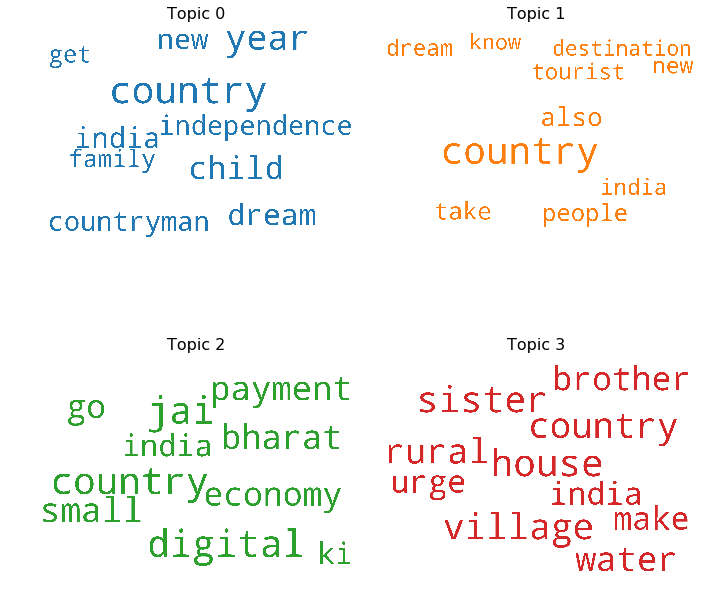

In [132]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [133]:
data_words = list(sent_to_words(imran_speech['text']))

print(data_words[:1])

[['am', 'happy', 'that', 'today', 'on', 'pakistan', 'independence', 'day', 'am', 'standing', 'here', 'with', 'my', 'brothers', 'in', 'kashmir', 'and', 'at', 'time', 'when', 'there', 'is', 'massive', 'crisis', 'being', 'inflicted', 'on', 'the', 'people', 'of', 'kashmir']]


In [134]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['am', 'happy', 'that', 'today', 'on', 'pakistan', 'independence', 'day', 'am', 'standing', 'here', 'with', 'my', 'brothers', 'in', 'kashmir', 'and', 'at', 'time', 'when', 'there', 'is', 'massive', 'crisis', 'being', 'inflicted', 'on', 'the', 'people', 'of', 'kashmir']


In [135]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['happy', 'today', 'pakistan', 'independence', 'day', 'stand', 'brother', 'kashmir', 'time', 'massive', 'crisis', 'inflict', 'people', 'kashmir']]


In [136]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [137]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('brother', 1),
  ('crisis', 1),
  ('day', 1),
  ('happy', 1),
  ('independence', 1),
  ('inflict', 1),
  ('kashmir', 2),
  ('massive', 1),
  ('pakistan', 1),
  ('people', 1),
  ('stand', 1),
  ('time', 1),
  ('today', 1)]]

In [138]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [139]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"india" + 0.026*"muslim" + 0.022*"ideology" + 0.017*"kashmir" + '
  '0.013*"play" + 0.013*"right" + 0.013*"would" + 0.009*"atrocity" + '
  '0.009*"community" + 0.009*"curfew"'),
 (1,
  '0.029*"kashmir" + 0.024*"muslim" + 0.018*"nation" + 0.016*"people" + '
  '0.013*"go" + 0.012*"stand" + 0.012*"united" + 0.010*"community" + '
  '0.009*"today" + 0.009*"world"'),
 (2,
  '0.036*"ideology" + 0.020*"kashmir" + 0.020*"world" + 0.016*"make" + '
  '0.012*"pakistan" + 0.012*"right" + 0.012*"principle" + 0.012*"people" + '
  '0.012*"islam" + 0.012*"india"'),
 (3,
  '0.018*"ideology" + 0.015*"modi" + 0.015*"kashmir" + 0.015*"take" + '
  '0.015*"today" + 0.012*"war" + 0.012*"world" + 0.009*"go" + 0.009*"fight" + '
  '0.009*"interest"'),
 (4,
  '0.027*"go" + 0.023*"muslim" + 0.018*"pakistan" + 0.018*"talk" + '
  '0.017*"community" + 0.012*"fully" + 0.012*"ready" + 0.012*"mind" + '
  '0.012*"league" + 0.012*"place"')]


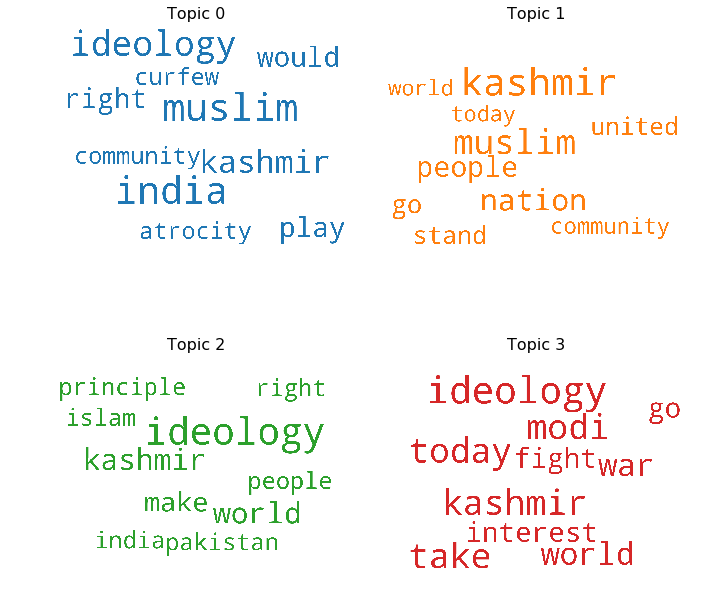

In [140]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()